In [101]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

In [160]:
def g6(pos, dr, r_cut=1.2):
    # Box dimension
    Lx, Ly = np.ptp(pos[:,0]), np.ptp(pos[:,1])
    r_max = 0.5*min(Lx, Ly)

    tree = cKDTree(pos)

    # --- ψ₆ (vectorized) ---
    sm = tree.sparse_distance_matrix(tree, r_cut, output_type="coo_matrix")
    i, j = sm.row, sm.col
    mask = i != j
    i, j = i[mask], j[mask]

    # bond vectors under minimum image
    dxy = pos[j] - pos[i]
    dxy[:,0] -= np.round(dxy[:,0]/Lx) * Lx
    dxy[:,1] -= np.round(dxy[:,1]/Ly) * Ly

    theta = np.arctan2(dxy[:,1], dxy[:,0])
    w = np.exp(1j * 6 * theta)

    # accumulate complex sums and counts
    N = pos.shape[0]
    sums = np.zeros(N, dtype=np.complex128)
    counts_i = np.zeros(N, dtype=np.int64)
    np.add.at(sums,      i, w)
    np.add.at(counts_i,  i, 1)

    psi6 = np.zeros(N, dtype=np.complex128)
    nonzero = counts_i > 0
    psi6[nonzero] = sums[nonzero] / counts_i[nonzero]
    psi6_mag2 = (np.abs(psi6) ** 2).mean()


    # --- g6(r) pair histogram (vectorized) ---
    sm2 = tree.sparse_distance_matrix(tree, r_max, output_type="coo_matrix")
    i2, j2 = sm2.row, sm2.col
    mask2 = i2 < j2
    i2, j2 = i2[mask2], j2[mask2]

    dxy2 = pos[j2] - pos[i2]
    dxy2[:,0] -= np.round(dxy2[:,0]/Lx) * Lx
    dxy2[:,1] -= np.round(dxy2[:,1]/Ly) * Ly
    r = np.hypot(dxy2[:,0], dxy2[:,1])

    nbins = int(np.ceil(r_max / dr))
    bin_idx = np.floor(r / dr).astype(int)

    weights = psi6[i2] * np.conj(psi6[j2])

    num    = np.bincount(bin_idx, minlength=nbins, weights=weights.real) \
           + 1j*np.bincount(bin_idx, minlength=nbins, weights=weights.imag)
    counts = np.bincount(bin_idx, minlength=nbins)

    r_cent = (np.arange(nbins) + 0.5) * dr
    with np.errstate(divide="ignore", invalid="ignore"):
        g6_r = (num/counts).real / psi6_mag2
    g6_r[counts == 0] = np.nan

    return r_cent, g6_r, counts

Thermal

In [183]:
from scipy.signal import find_peaks
a = 1.42

plt.figure(figsize=(16,8), dpi=800)
for label, fname, color, rcut, fit in [
        (r'$\Gamma = 11.200$',  'data/thermal/7000K.txt', "cyan",      1.2, None), # crystal
        (r'$\Gamma = 9.555$',  'data/thermal/8125K.txt',  "green",     1.2, None), # crystal
        (r'$\Gamma = 8.787$',  'data/thermal/8250K.txt',  "orange",    1.2, "power"), # hexatic
        (r'$\Gamma = 8.307$',  'data/minimized/8500K_min.txt',  "orangered", 1.1, "exp")]:

    pos = np.loadtxt(fname)[:,2:4] / a
    r, g6_r, _ = g6(pos, dr=0.075)
    g6_r *= 1.1
    plt.loglog(r, gaussian_filter1d(np.nan_to_num(g6_r, nan=0.0), sigma=2), c=color, label=label, lw=2)

    if fit=="exp":
        i1 = np.argmin(np.abs(r - 1.0))
        A = g6_r[i1]
        exp_model = lambda r, xi: A * np.exp(-r/xi)    
        rmin, rmax = 1.0 ,20.0
        mask = (r >= rmin) & (r <= rmax) & (g6_r > 0)
        p0 = [g6_r[mask][0], (rmax - rmin)/2]
        popt, pcov = curve_fit(exp_model,r[mask], g6_r[mask], p0=[(rmax - rmin)/2])
        xi6 = popt[0]
        xi_err = np.sqrt(np.diag(pcov))[0]
        xi6 = popt[0]
        plt.loglog(r, exp_model(r, xi6), ls='--', c=color, lw=2, label=r'$\sim e^{{-r/\xi_6}},\,\xi_6=$' + f'{xi6:.2f}')
    
    if fit=="power":
        peaks, _ = find_peaks(g6_r, distance=int(1.0/0.085))
        r_peaks = r[peaks]
        g_peaks = g6_r[peaks]
        i1 = np.argmin(np.abs(r_peaks - 1.0))
        A0 = g6_r[peaks][i1]   
        power_model = lambda r,eta: A0*r**(-eta)
        rmin, rmax = 1.0, 30.0
        mask = (r_peaks >= rmin) & (r_peaks <= rmax)
        ln_r = np.log(r_peaks[mask])
        ln_g = np.log(g_peaks[mask])
        m, c = np.polyfit(ln_r, ln_g, 1)
        eta = -m             
        A   = np.exp(c)
        fit_power = A * r**(-eta)
        plt.loglog(r, fit_power, '--', c=color, lw=2, label=r'$\sim r^{{-\eta}},\,\eta=$' + f'{eta:.2f}')

    
# reference r^{-1/4} line
plt.loglog(r, 0.7 * r**(-1/4), c="k", label=r"$\sim r^{-1/4}$", lw=2)

# styling
x_ticks = list(range(1, 11)) + [20, 30, 40, 50, 100]
plt.xticks(x_ticks, [str(t) for t in x_ticks], fontsize=14)
plt.yticks([1.0, 0.1, 0.01], ["1.0", "0.1", "0.01"],fontsize=14)
plt.xlabel(r'$r/a$', fontsize=20)
plt.ylabel(r'$g_6(r)$', fontsize=24)
plt.xlim(1, 60)
plt.ylim(1e-2, 1)
plt.grid(True, which="both", ls="--")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=12)
plt.tight_layout()
plt.savefig("thermal.pdf")
plt.show()

In [189]:
from scipy.signal import find_peaks
a = 1.42

plt.figure(figsize=(16,8), dpi=800)
for label, fname, color, rcut, fit in [
        (r'$\Gamma =$',  '../output/GAMMAS/8200/anneal_8200K.data', "blue",      1.2, None)]:
    pos = np.loadtxt(fname, skiprows=14)[:,2:4] / a + np.random.normal(loc=0.0, scale=0.02, size=(pos.shape))
    r, g6_r, _ = g6(pos, dr=0.075)
    plt.loglog(r, gaussian_filter1d(np.nan_to_num(g6_r, nan=0.0), sigma=1), c=color, label=label, lw=2)

# reference r^{-1/4} line
plt.loglog(r, 0.7 * r**(-1/4), c="k", label=r"$\sim r^{-1/4}$", lw=2)

# styling
x_ticks = list(range(1, 11)) + [20, 30, 40, 50, 100]
plt.xticks(x_ticks, [str(t) for t in x_ticks], fontsize=14)
plt.yticks([1.0, 0.1, 0.01], ["1.0", "0.1", "0.01"],fontsize=14)
plt.xlabel(r'$r/a$', fontsize=20)
plt.ylabel(r'$g_6(r)$', fontsize=24)
plt.xlim(1, 15)
plt.ylim(1e-2, 1)
plt.grid(True, which="both", ls="--")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=12)
plt.tight_layout()
plt.savefig("thermal.pdf")
plt.show()

Structural

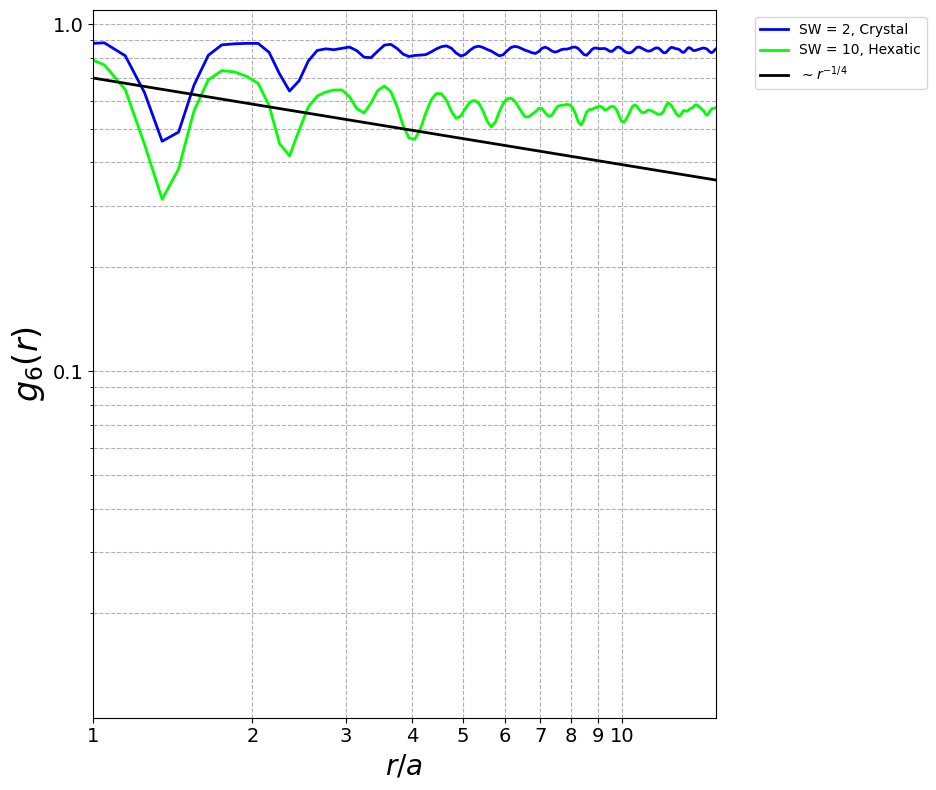

In [177]:
from scipy.signal import find_peaks
a = 1.42

plt.figure(figsize=(10,8))
for label, fname, color, rcut, fit in [
        (r'SW = 2, Crystal',  'data/thermal/7000K.txt', "blue", 1.1, None),
        (r'SW = 10, Hexatic',  'data/defects/test.txt', "lime", 1.1, None)]:

    pos = np.loadtxt(fname)[:,2:4] / a
    r, g6_r, _ = g6(pos, dr=0.1)
    g6_r*=1.02
    plt.loglog(r, gaussian_filter1d(np.nan_to_num(g6_r, nan=0.0), sigma=1), c=color, label=label, lw=2)


plt.loglog(r, 0.7 * r**(-1/4), c="k", label=r"$\sim r^{-1/4}$", lw=2)
# styling
x_ticks = list(range(1, 11)) + [20, 30, 40, 50, 100]
plt.xticks(x_ticks, [str(t) for t in x_ticks], fontsize=14)
plt.yticks([1.0, 0.1], ["1.0", "0.1"],fontsize=14)
plt.xlabel(r'$r/a$', fontsize=20)
plt.ylabel(r'$g_6(r)$', fontsize=24)
plt.xlim(1, 15)
plt.ylim(1e-2, 1.1)
plt.grid(True, which="both", ls="--")
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.tight_layout()
plt.show()

In [184]:
def gT(pos, dr, G0):
    """
    Radial translational correlation G_T(r) using an effective Bragg magnitude G0,
    averaged over the six 60°-spaced directions.
    
    Parameters
    ----------
    pos : (N,2) array
        Particle positions.
    dr : float
        Bin width in r.
    G0 : float
        Magnitude of the first Bragg peak (~4.2 in 1/a).
    box : tuple (Lx,Ly), optional
        If given, apply minimum-image with these periodic lengths.
    
    Returns
    -------
    r_cent : (nbins,) array of bin centers
    gT_r   : (nbins,) real array of G_T(r)
    counts : (nbins,) int array of pair counts
    """
    # --- box & r_max ---
    Lx = np.ptp(pos[:,0])+10
    Ly = np.ptp(pos[:,1])+10
    box=(Lx,Ly)
    r_max = 0.5 * min(Lx, Ly)
    nbins = int(np.ceil(r_max/dr))
    
    # --- build k-vectors Gₗ ---
    thetas = np.arange(6) * np.pi/3
    Gs = np.stack([G0 * np.column_stack((np.cos(thetas), np.sin(thetas)))])[0]  # shape (6,2)
    
    # --- build neighbor pairs ---
    tree = cKDTree(pos)
    sm = tree.sparse_distance_matrix(tree, r_max, output_type="coo_matrix")
    i2, j2 = sm.row, sm.col
    mask = i2 < j2
    i2, j2 = i2[mask], j2[mask]
    
    # --- get separations with optional PBC ---
    dxy = pos[j2] - pos[i2]
    if box is not None:
        dxy[:,0] -= np.round(dxy[:,0]/box[0]) * box[0]
        dxy[:,1] -= np.round(dxy[:,1]/box[1]) * box[1]
    r = np.hypot(dxy[:,0], dxy[:,1])
    
    # --- bin indices (drop any ==nbins) ---
    bin_idx = np.floor(r/dr).astype(int)
    valid = (bin_idx >= 0) & (bin_idx < nbins)
    bin_idx = bin_idx[valid]
    i2 = i2[valid]
    j2 = j2[valid]
    
    # --- precompute psi_T for each Gₗ and each particle ---
    # psi_T[ℓ,k] = exp(i Gₗ · r_k)
    psi_T = np.exp(1j * (pos @ Gs.T))  # shape (N,6)
    
    # --- accumulate numerator and counts ---
    num = np.zeros(nbins, dtype=np.complex128)
    counts = np.bincount(bin_idx, minlength=nbins)
    
    # sum over the six directions ℓ
    for ell in range(6):
        w = psi_T[i2, ell] * np.conj(psi_T[j2, ell])
        np.add.at(num, bin_idx, w)
    
    # average over directions
    num /= 6.0
    
    # --- form G_T(r) ---
    with np.errstate(divide="ignore", invalid="ignore"):
        gT_r = (num / counts).real
    gT_r[counts == 0] = np.nan
    
    r_cent = (np.arange(nbins) + 0.5) * dr
    return r_cent, gT_r, counts